In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Bootstrapping by hand
To help you gain intuition about how bootstrapping works, imagine you have a data set that has only three points, [-1, 0, 1]. How many unique bootstrap samples can be drawn (e.g., [-1, 0, 1] and [1, 0, -1] are unique), and what is the maximum mean you can get from a bootstrap sample? It might be useful to jot down the samples on a piece of paper.

(These are too few data to get meaningful results from bootstrap procedures, but this example is useful for intuition.)

### Visualizing bootstrap samples
In this exercise, you will generate bootstrap samples from the set of annual rainfall data measured at the Sheffield Weather Station in the UK from 1883 to 2015. The data are stored in the NumPy array rainfall in units of millimeters (mm). By graphically displaying the bootstrap samples with an ECDF, you can get a feel for how bootstrap sampling allows probabilistic descriptions of data.

In [6]:
cat sheffield_weather_station.csv|head -n 15

# Cleaned up from http://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/sheffielddata.txt
# More info: https://data.gov.uk/dataset/historic-monthly-meteorological-station-data
# Sheffield
# Location 433900E 387200N, Lat 53.381 Lon -1.490, 131 metres amsl
# Missing data (more than 2 days missing in month) is marked by  ---.
# (af is air frost)
#    yyyy  mm   tmax    tmin      af    rain     sun
#               degC    degC    days      mm   hours
   yyyy  mm   tmax    tmin      af    rain     sun
   1883   1    6.3     1.7       6   122.1     ---
   1883   2    8.0     2.8       2    69.8     ---
   1883   3    4.8    -1.6      23    29.6     ---
   1883   4   12.2     3.8       2    74.0     ---
   1883   5   14.7     6.2       0    31.2     ---
   1883   6   17.7     9.3       0    66.2     ---
cat: write error: Broken pipe


In [16]:
df = pd.read_fwf('./sheffield_weather_station.csv', skiprows=8)
print df.shape
df.head()

(1602, 7)


,yyyy,mm,tmax,tmin,af,rain,sun
0,1883,1,6.3,1.7,6,122.1,---
1,1883,2,8.0,2.8,2,69.8,---
2,1883,3,4.8,-1.6,23,29.6,---
3,1883,4,12.2,3.8,2,74.0,---
4,1883,5,14.7,6.2,0,31.2,---


In [19]:
rainfall = df['rain'].astype(float)
def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1)/float(len(data))

In [23]:
np.random.choice(rainfall, size=5)

array([ 25.3,  60.7,  58.2, 106.2,  52.8])

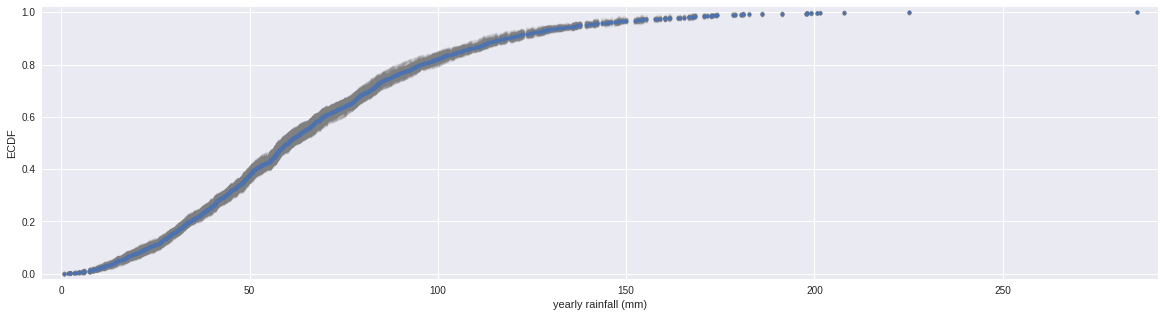

In [21]:
plt.figure(figsize=[20,5])
for _ in range(50):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(rainfall, size=len(rainfall))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(x, y, marker='.', linestyle='none',
                 color='gray', alpha=0.1)

# Compute and plot ECDF from original data
x, y = ecdf(rainfall)
_ = plt.plot(x, y, '.')

# Make margins and label axes
plt.margins(0.02)
_ = plt.xlabel('yearly rainfall (mm)')
_ = plt.ylabel('ECDF')

# Show the plot
plt.show()


In [25]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

### Generating many bootstrap replicates

Now you'll write another function, draw_bs_reps(data, func, size=1), which generates many bootstrap replicates from the data set. This function will come in handy for you again and again as you compute confidence intervals and later when you do hypothesis tests.


In [26]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

### Bootstrap replicates of the mean and the SEM
In this exercise, you will compute a bootstrap estimate of the probability distribution function of the mean annual rainfall at the Sheffield Weather Station. Remember, we are estimating the mean annual rainfall we would get if the Sheffield Weather Station could repeat all of the measurements from 1883 to 2015 over and over again. This is a probabilistic estimate of the mean. You will plot the PDF as a histogram, and you will see that it is Normal.

In fact, it can be shown theoretically that under not-too-restrictive conditions, the value of the mean will always be Normally distributed. (This does not hold in general, just for the mean and a few other statistics.) 

The standard deviation of this distribution, called the standard error of the mean, or SEM, is given by the standard deviation of the data divided by the square root of the number of data points. 

I.e., for a data set, sem = np.std(data) / np.sqrt(len(data)). Using hacker statistics, you get this same result without the need to derive it, but you will verify this result from your bootstrap replicates.

The dataset has been pre-loaded for you into an array called rainfall.

0.9488593574676786
0.9493849710983365


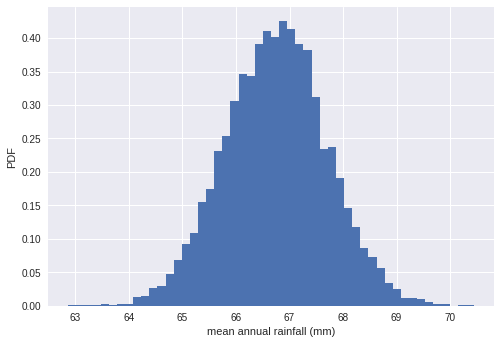

In [27]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.mean, size=10000)

# Compute and print SEM
sem = np.std(rainfall) / np.sqrt(len(rainfall))
print(sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print(bs_std)

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel('mean annual rainfall (mm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

### Confidence intervals of rainfall data
A confidence interval gives bounds on the range of parameter values you might expect to get if we repeated our measurements. For named distributions, you can compute them analytically or look them up, but one of the many beautiful properties of the bootstrap method is that you can just take percentiles of your bootstrap replicates to get your confidence interval. Conveniently, you can use the np.percentile() function.

Using your bootstrap replicates you just generated to compute the 95% confidence interval. That is, give the 2.5th and 97.5th percentile of your bootstrap replicates stored as bs_replicates.

In [28]:
np.percentile(bs_replicates, [2.5, 97.5])

array([64.88067884, 68.61300406])

### Bootstrap replicates of other statistics
We saw in a previous exercise that the mean is Normally distributed. This does not necessarily hold for other statistics, but no worry: as hackers, we can always take bootstrap replicates! In this exercise, you'll generate bootstrap replicates for the variance of the annual rainfall at the Sheffield Weather Station and plot the histogram of the replicates.


In [32]:
def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])

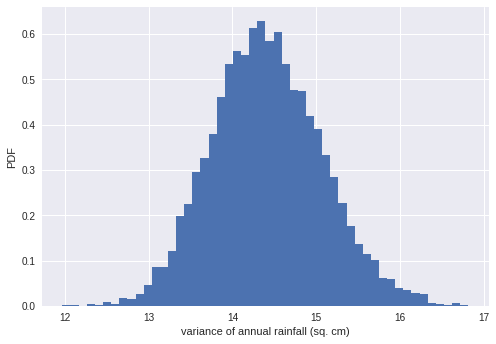

In [33]:
# Generate 10,000 bootstrap replicates of the variance: bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.var, size=10000)

# Put the variance in units of square centimeters
bs_replicates /= 100

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel('variance of annual rainfall (sq. cm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()


In [35]:
nohitter_times = np.array([ 843, 1613, 1101,  215,  684,  814,  278,  324,  161,  219,  545,
        715,  966,  624,   29,  450,  107,   20,   91, 1325,  124, 1468,
        104, 1309,  429,   62, 1878, 1104,  123,  251,   93,  188,  983,
        166,   96,  702,   23,  524,   26,  299,   59,   39,   12,    2,
        308, 1114,  813,  887,  645, 2088,   42, 2090,   11,  886, 1665,
       1084, 2900, 2432,  750, 4021, 1070, 1765, 1322,   26,  548, 1525,
         77, 2181, 2752,  127, 2147,  211,   41, 1575,  151,  479,  697,
        557, 2267,  542,  392,   73,  603,  233,  255,  528,  397, 1529,
       1023, 1194,  462,  583,   37,  943,  996,  480, 1497,  717,  224,
        219, 1531,  498,   44,  288,  267,  600,   52,  269, 1086,  386,
        176, 2199,  216,   54,  675, 1243,  463,  650,  171,  327,  110,
        774,  509,    8,  197,  136,   12, 1124,   64,  380,  811,  232,
        192,  731,  715,  226,  605,  539, 1491,  323,  240,  179,  702,
        156,   82, 1397,  354,  778,  603, 1001,  385,  986,  203,  149,
        576,  445,  180, 1403,  252,  675, 1351, 2983, 1568,   45,  899,
       3260, 1025,   31,  100, 2055, 4043,   79,  238, 3931, 2351,  595,
        110,  215,    0,  563,  206,  660,  242,  577,  179,  157,  192,
        192, 1848,  792, 1693,   55,  388,  225, 1134, 1172, 1555,   31,
       1582, 1044,  378, 1687, 2915,  280,  765, 2819,  511, 1521,  745,
       2491,  580, 2072, 6450,  578,  745, 1075, 1103, 1549, 1520,  138,
       1202,  296,  277,  351,  391,  950,  459,   62, 1056, 1128,  139,
        420,   87,   71,  814,  603, 1349,  162, 1027,  783,  326,  101,
        876,  381,  905,  156,  419,  239,  119,  129,  467])

### Confidence interval on the rate of no-hitters
Consider again the inter-no-hitter intervals for the modern era of baseball. Generate 10,000 bootstrap replicates of the optimal parameter ττ. Plot a histogram of your replicates and report a 95% confidence interval.

('95% confidence interval =', array([662.56215139, 870.22370518]), 'games')


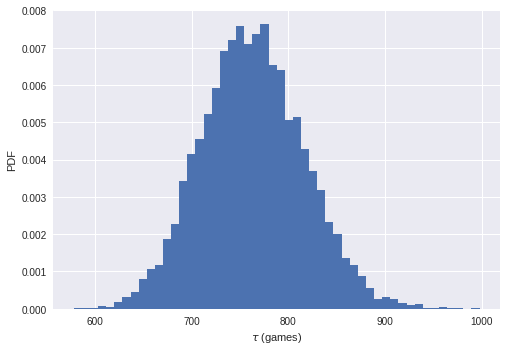

In [36]:
# Draw bootstrap replicates of the mean no-hitter time (equal to tau): bs_replicates
bs_replicates = draw_bs_reps(nohitter_times, np.mean, size=10000)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

# Plot the histogram of the replicates
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel(r'$\tau$ (games)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()


### A function to do pairs bootstrap
As discussed in the video, pairs bootstrap involves resampling pairs of data. Each collection of pairs fit with a line, in this case using np.polyfit(). We do this again and again, getting bootstrap replicates of the parameter values. To have a useful tool for doing pairs bootstrap, you will write a function to perform pairs bootstrap on a set of x,y data.

In [37]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps


### Pairs bootstrap of literacy/fertility data
Using the function you just wrote, perform pairs bootstrap to plot a histogram describing the estimate of the slope from the illiteracy/fertility data. Also report the 95% confidence interval of the slope. The data is available to you in the NumPy arrays illiteracy and fertility.

As a reminder, draw_bs_pairs_linreg() has a function signature of draw_bs_pairs_linreg(x, y, size=1), and it returns two values: bs_slope_reps and bs_intercept_reps.

In [39]:
df = pd.read_csv('./female_literacy_fertility.csv')
print df.shape
illiteracy, fertility = 100 - df['female literacy'], df['fertility']

df.head()

(162, 5)


,Country,Continent,female literacy,fertility,population
0,Chine,ASI,90.5,1.769,"1,324,655,000"
1,Inde,ASI,50.8,2.682,"1,139,964,932"
2,USA,NAM,99.0,2.077,"304,060,000"
3,Indonésie,ASI,88.8,2.132,"227,345,082"
4,Brésil,LAT,90.2,1.827,"191,971,506"


[0.04469634 0.05514585]


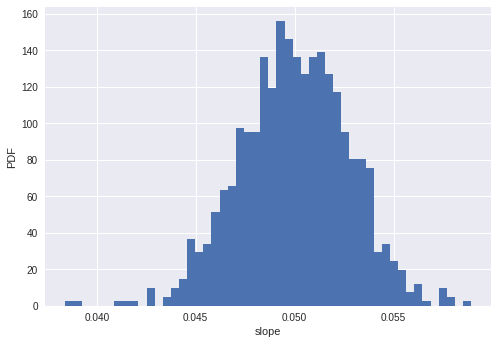

In [40]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(
                    illiteracy, fertility, size=1000)

# Compute and print 95% CI for slope
print(np.percentile(bs_slope_reps, [2.5, 97.5]))

# Plot the histogram
_ = plt.hist(bs_slope_reps, bins=50, normed=True)
_ = plt.xlabel('slope')
_ = plt.ylabel('PDF')
plt.show()

### Plotting bootstrap regressions
A nice way to visualize the variability we might expect in a linear regression is to plot the line you would get from each bootstrap replicate of the slope and intercept. Do this for the first 100 of your bootstrap replicates of the slope and intercept (stored as bs_slope_reps and bs_intercept_reps).

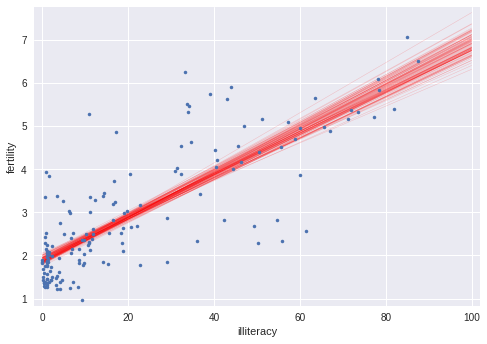

In [41]:
# Generate array of x-values for bootstrap lines: x
x = np.array([0, 100])

# Plot the bootstrap lines
for i in range(100):
    _ = plt.plot(x, bs_slope_reps[i] * x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='red')

# Plot the data
_ = plt.plot(illiteracy, fertility, marker='.', linestyle='none')

# Label axes, set the margins, and show the plot
_ = plt.xlabel('illiteracy')
_ = plt.ylabel('fertility')
plt.margins(0.02)
plt.show()